In [ ]:
# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI/hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,city
0,Resort Hotel - Chandigarh,0,342,2024,July,30,27,0,0,2,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,16:40.9,Chandigarh
1,Resort Hotel - Mumbai,0,737,2024,April,17,28,0,0,2,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,56:21.5,Mumbai
2,Resort Hotel - Delhi,0,7,2024,September,37,10,0,1,1,...,NaN,NaN,0,Transient,75.0,0,0,Check-Out,46:25.7,Delhi
3,Resort Hotel - Kolkata,0,13,2024,August,33,14,0,1,1,...,304.0,NaN,0,Transient,75.0,0,0,Check-Out,07:10.1,Kolkata
4,Resort Hotel - Lucknow,0,14,2024,September,37,14,0,2,2,...,240.0,NaN,0,Transient,98.0,0,1,Check-Out,27:32.5,Lucknow


In [ ]:
df.shape

(119390, 33)

In [ ]:
missing = df.isnull().sum()
missing[missing > 0]

,0
children,4
country,488
agent,16340
company,112593


In [ ]:
# Fill missing values
df['children'] = df['children'].fillna(0)  # Assume no children if missing
df['country'] = df['country'].fillna('Unknown')
df['agent'] = df['agent'].fillna(0)  # 0 means no agent
df['company'] = df['company'].fillna(0)  # 0 means no company
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], errors='coerce')

# Verify
df.isnull().sum().sum()

/tmp/ipython-input-4105769618.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], errors='coerce')


np.int64(71555)

In [ ]:
df.dtypes


,0
hotel,object
is_canceled,int64
lead_time,int64
arrival_date_year,int64
arrival_date_month,object
arrival_date_week_number,int64
arrival_date_day_of_month,int64
stays_in_weekend_nights,int64
stays_in_week_nights,int64
adults,int64


In [ ]:
df['children'] = df['children'].astype(int)
df['agent'] = df['agent'].astype(int)
df['company'] = df['company'].astype(int)

df[['children', 'agent', 'company']].dtypes


,0
children,int64
agent,int64
company,int64


In [ ]:
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df['arrival_date_month'] = df['arrival_date_month'].map(month_map)

df['arrival_date_month'].head()


,arrival_date_month
0,7
1,4
2,9
3,8
4,9


In [ ]:
df.columns.tolist()

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status',
 'reservation_status_date',
 'city']

In [ ]:
df.duplicated().sum()

np.int64(16)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape


(119374, 33)

In [ ]:
#remove invalid rows with 0 people

df = df[~((df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0))]

df.shape


(119194, 33)

In [ ]:
df['lead_time'].describe()

,lead_time
count,119194.000000
mean,104.097413
std,106.869001
min,0.000000
25%,18.000000
50%,69.000000
75%,160.000000
max,737.000000


In [ ]:
# Remove negative ADR
df = df[df['adr'] >= 0]

# Cap extreme high values at 99th percentile
cap = df['adr'].quantile(0.99)
df['adr'] = df['adr'].clip(upper=cap)

In [ ]:
df['adr'].describe()

,adr
count,119193.000000
mean,101.601170
std,46.792205
min,0.000000
25%,69.500000
50%,94.950000
75%,126.000000
max,252.000000


In [ ]:
# Cap other numeric outliers
num_cols = ['lead_time', 'stays_in_week_nights', 'stays_in_weekend_nights']
for col in num_cols:
    cap = df[col].quantile(0.99)
    df[col] = df[col].clip(upper=cap)
df[num_cols].describe()

,lead_time,stays_in_week_nights,stays_in_weekend_nights
count,119193.000000,119193.000000,119193.000000
mean,103.493418,2.479005,0.919685
std,104.603791,1.758485,0.956370
min,0.000000,0.000000,0.000000
25%,18.000000,1.000000,0.000000
50%,69.000000,2.000000,1.000000
75%,160.000000,3.000000,2.000000
max,444.000000,10.000000,4.000000


In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols

Index(['hotel', 'meal', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'deposit_type',
       'customer_type', 'reservation_status', 'city'],
      dtype='object')

In [ ]:
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")

hotel: 30 unique values
meal: 5 unique values
country: 178 unique values
market_segment: 8 unique values
distribution_channel: 5 unique values
reserved_room_type: 9 unique values
assigned_room_type: 11 unique values
deposit_type: 3 unique values
customer_type: 4 unique values
reservation_status: 3 unique values
city: 15 unique values


In [ ]:
le = LabelEncoder()
df['country_encoded'] = le.fit_transform(df['country'])
df = df.drop(columns=['country'])

In [ ]:
df['country_encoded'].head()

,country_encoded
0,135
1,135
2,59
3,59
4,59


In [ ]:
cat_to_onehot = ['hotel', 'meal', 'market_segment', 'distribution_channel',
                 'reserved_room_type', 'assigned_room_type',
                 'deposit_type', 'customer_type', 'city']

df = pd.get_dummies(df, columns=cat_to_onehot, drop_first=True)

In [ ]:
df.shape

(119193, 105)

In [ ]:
#handle rare categories in 'country_encoded'
country_counts = df['country_encoded'].value_counts()
rare_countries = country_counts[country_counts < 30].index  # threshold can be tuned

df['country_encoded'] = df['country_encoded'].replace(rare_countries, -1)

In [ ]:
df['total_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['total_people'] = df['adults'] + df['children'] + df['babies']

In [ ]:
df[['stays_in_weekend_nights', 'stays_in_week_nights', 'total_stay','total_people']].head()

,stays_in_weekend_nights,stays_in_week_nights,total_stay,total_people
0,0,0,0,2
1,0,0,0,2
2,0,1,1,1
3,0,1,1,1
4,0,2,2,2


In [ ]:
# Avoid division by zero
df['adr_per_person'] = df['adr'] / df['total_people'].replace(0, 1)

# Family indicator
df['is_family'] = ((df['children'] + df['babies']) > 0).astype(int)

df[['total_stay', 'total_people', 'adr_per_person', 'is_family']].head()

,total_stay,total_people,adr_per_person,is_family
0,0,2,0.0,0
1,0,2,0.0,0
2,1,1,75.0,0
3,1,1,75.0,0
4,2,2,49.0,0


In [ ]:
# Drop useless or leaking columns
cols_to_drop = [
    'company',                 # ID-like, mostly useless
    'agent',                   # ID-like
    'reservation_status',      # Leaks cancellation info
]

df = df.drop(columns=cols_to_drop, errors='ignore')


In [ ]:
# Check class balance
df['is_canceled'].value_counts(normalize=True)


,proportion
is_canceled,
0,0.629282
1,0.370718


In [ ]:
df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,city_Jaipur,city_Kochi,city_Kolkata,city_Lucknow,city_Mumbai,city_Pune,total_stay,total_people,adr_per_person,is_family
0,0,342,2024,7,30,27,0,0,2,0,...,False,False,False,False,False,False,0,2,0.0,0
1,0,444,2024,4,17,28,0,0,2,0,...,False,False,False,False,True,False,0,2,0.0,0
2,0,7,2024,9,37,10,0,1,1,0,...,False,False,False,False,False,False,1,1,75.0,0
3,0,13,2024,8,33,14,0,1,1,0,...,False,False,True,False,False,False,1,1,75.0,0
4,0,14,2024,9,37,14,0,2,2,0,...,False,False,False,True,False,False,2,2,49.0,0


In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('is_canceled')

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/AI/hotel_bookings_cleaned.csv', index=False)

In [ ]:

os.path.getsize('/content/drive/MyDrive/Colab Notebooks/AI/hotel_bookings_cleaned.csv')

111460613

/tmp/ipython-input-798390826.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_canceled', y='count', data=cancellation_counts, palette='viridis')


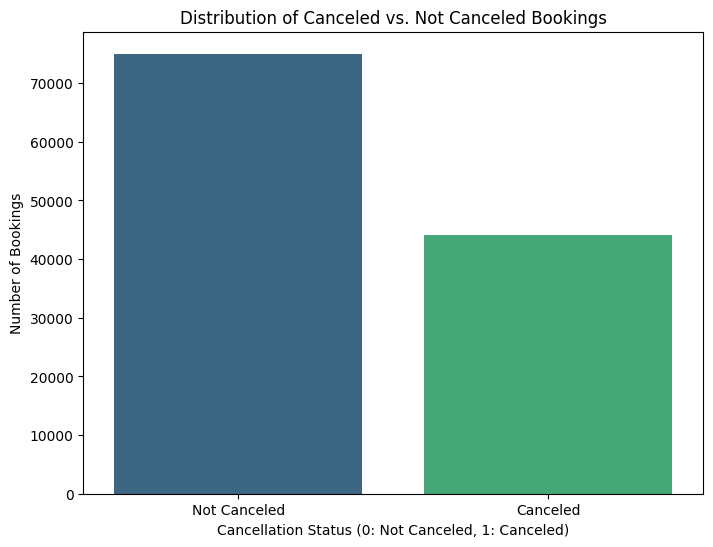

In [ ]:


cancellation_counts = df['is_canceled'].value_counts().reset_index()
cancellation_counts.columns = ['is_canceled', 'count']

plt.figure(figsize=(8, 6))
sns.barplot(x='is_canceled', y='count', data=cancellation_counts, palette='viridis')
plt.title('Distribution of Canceled vs. Not Canceled Bookings')
plt.xlabel('Cancellation Status (0: Not Canceled, 1: Canceled)')
plt.ylabel('Number of Bookings')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.show()

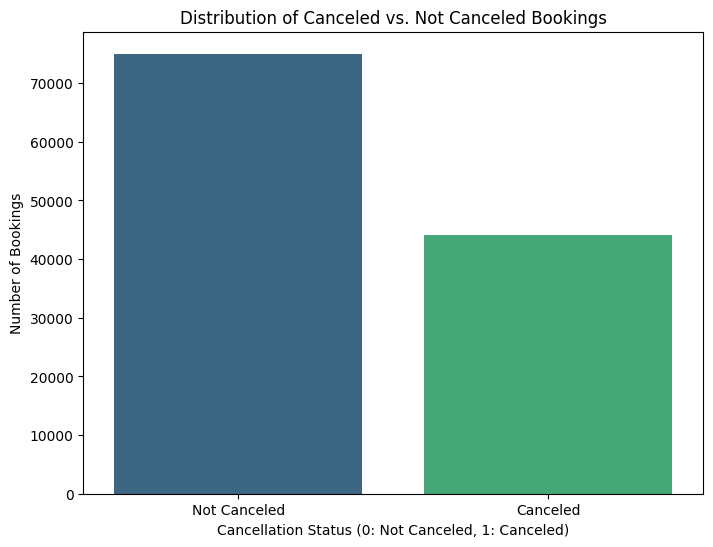

In [ ]:


cancellation_counts = df['is_canceled'].value_counts().reset_index()
cancellation_counts.columns = ['is_canceled', 'count']

plt.figure(figsize=(8, 6))
sns.barplot(x='is_canceled', y='count', hue='is_canceled', data=cancellation_counts, palette='viridis', legend=False)
plt.title('Distribution of Canceled vs. Not Canceled Bookings')
plt.xlabel('Cancellation Status (0: Not Canceled, 1: Canceled)')
plt.ylabel('Number of Bookings')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.show()

/tmp/ipython-input-2577429600.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='arrival_date_month', y='booking_count', data=monthly_bookings, palette='Spectral')


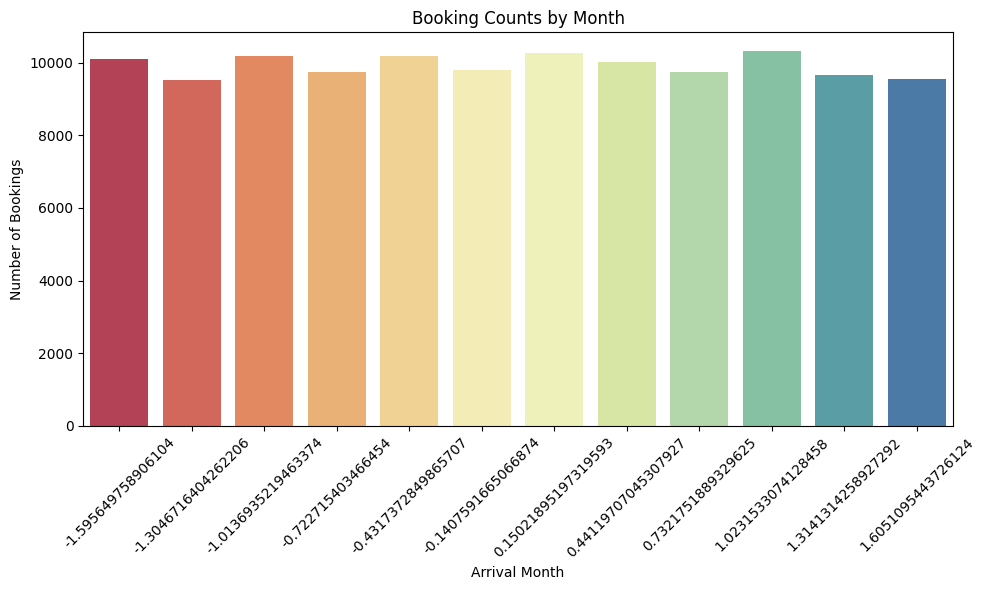

In [ ]:
monthly_bookings = df.groupby('arrival_date_month').size().reset_index(name='booking_count')

plt.figure(figsize=(10, 6))
sns.barplot(x='arrival_date_month', y='booking_count', data=monthly_bookings, palette='Spectral')
plt.title('Booking Counts by Month')
plt.xlabel('Arrival Month')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

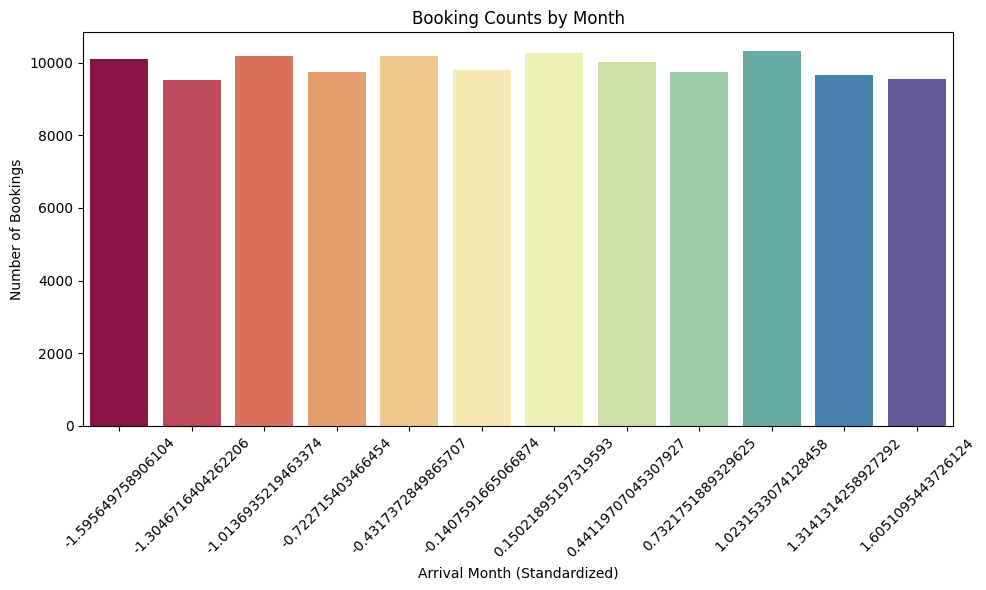

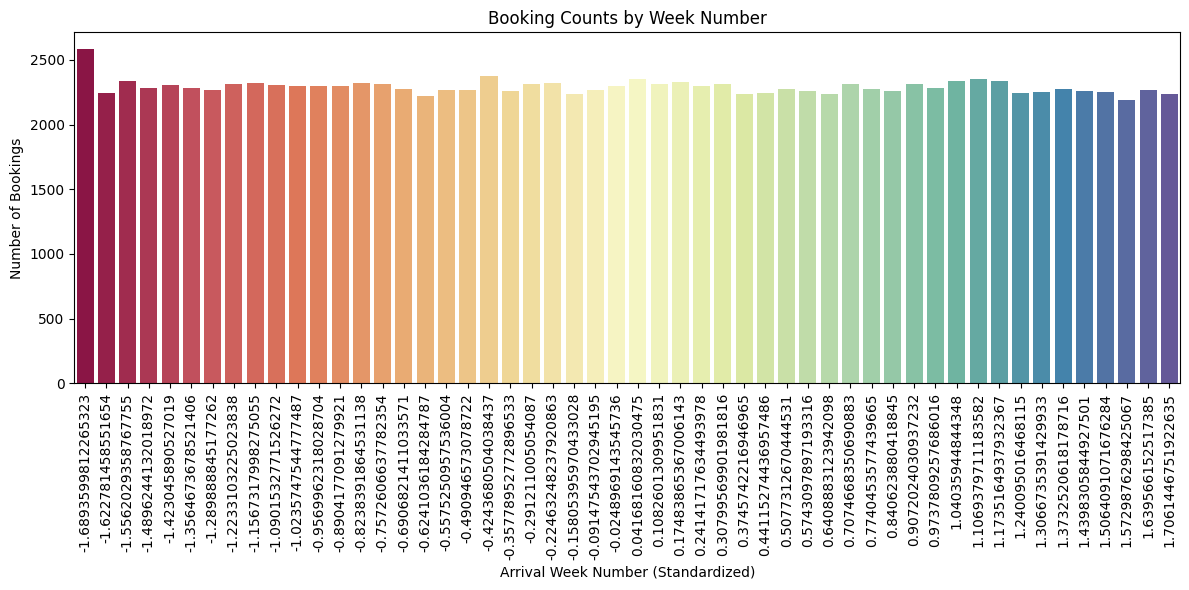

In [ ]:
monthly_bookings = df.groupby('arrival_date_month').size().reset_index(name='booking_count')

plt.figure(figsize=(10, 6))
sns.barplot(x='arrival_date_month', y='booking_count', hue='arrival_date_month', data=monthly_bookings, palette='Spectral', legend=False)
plt.title('Booking Counts by Month')
plt.xlabel('Arrival Month (Standardized)')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Group by arrival_date_week_number and count bookings
weekly_bookings = df.groupby('arrival_date_week_number').size().reset_index(name='booking_count')

plt.figure(figsize=(12, 6))
sns.barplot(x='arrival_date_week_number', y='booking_count', hue='arrival_date_week_number', data=weekly_bookings, palette='Spectral', legend=False)
plt.title('Booking Counts by Week Number')
plt.xlabel('Arrival Week Number (Standardized)')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

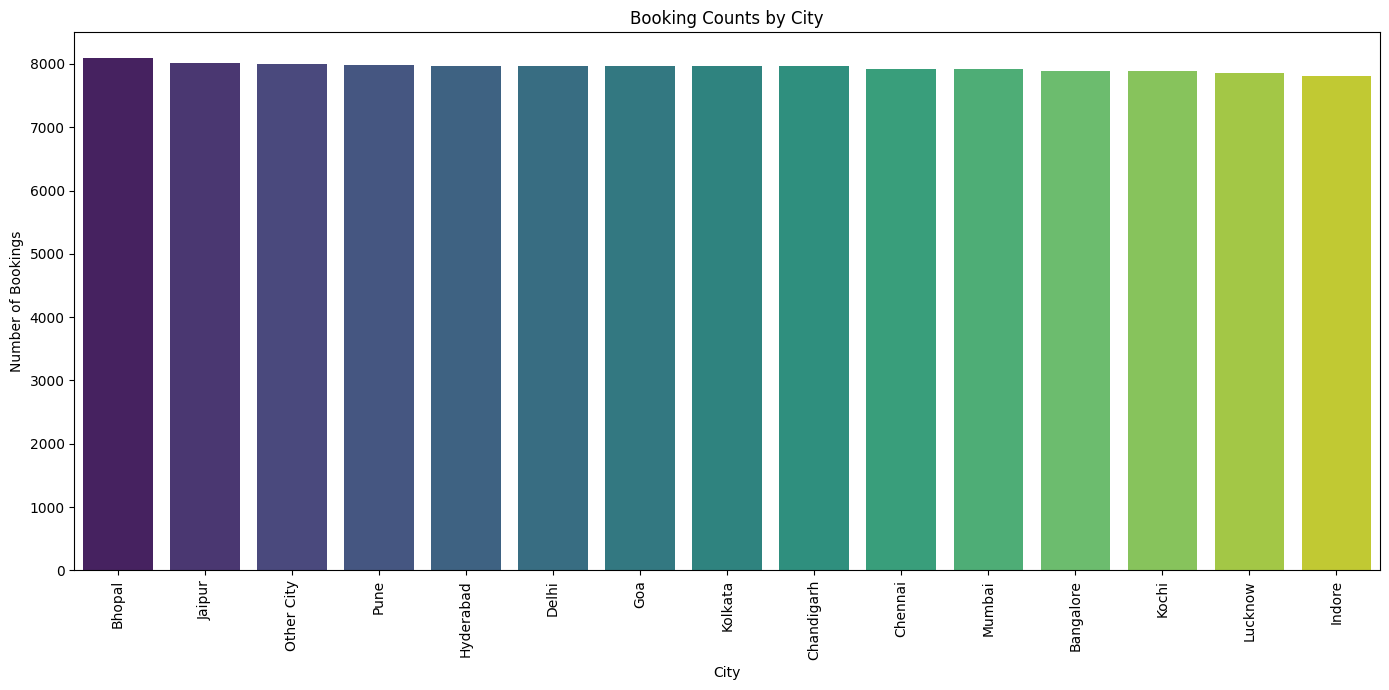

In [ ]:
city_columns = [col for col in df.columns if col.startswith('city_')]
city_booking_counts = pd.DataFrame(columns=['city', 'booking_count'])

for col in city_columns:
    city_name = col.replace('city_', '')
    count = df[col].sum()
    city_booking_counts = pd.concat([city_booking_counts, pd.DataFrame([{'city': city_name, 'booking_count': count}])], ignore_index=True)

# Calculate bookings for the 'other' category (the one implicitly dropped by drop_first=True)
total_explicit_city_bookings = city_booking_counts['booking_count'].sum()
total_bookings = len(df)
other_city_bookings = total_bookings - total_explicit_city_bookings

# Add 'Other City' if there are bookings not accounted for by the explicit one-hot encoded columns
if other_city_bookings > 0:
    city_booking_counts = pd.concat([city_booking_counts, pd.DataFrame([{'city': 'Other City', 'booking_count': other_city_bookings}])], ignore_index=True)

# Sort the cities by booking count for better visualization
city_booking_counts = city_booking_counts.sort_values(by='booking_count', ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x='city', y='booking_count', hue='city', data=city_booking_counts, palette='viridis', legend=False)
plt.title('Booking Counts by City')
plt.xlabel('City')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

/tmp/ipython-input-527902695.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_canceled', y='adr_per_person', data=df, palette='viridis')


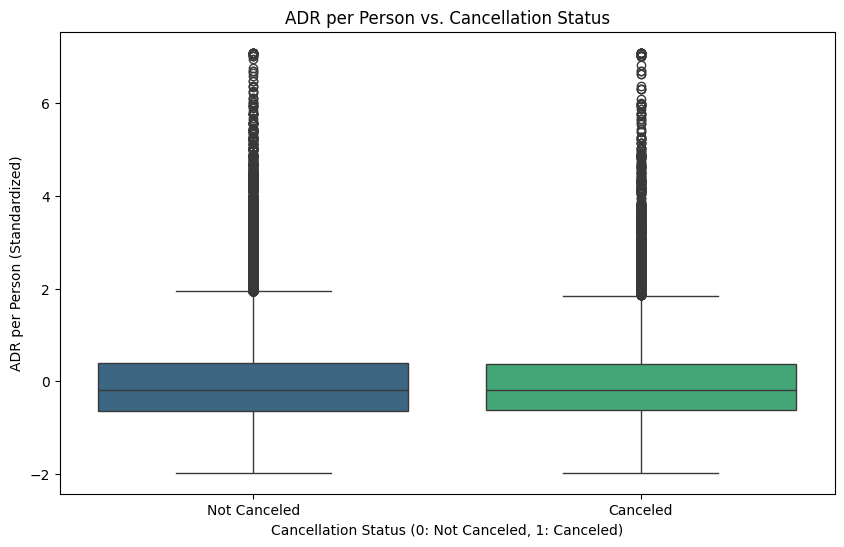

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_canceled', y='adr_per_person', data=df, palette='viridis')
plt.title('ADR per Person vs. Cancellation Status')
plt.xlabel('Cancellation Status (0: Not Canceled, 1: Canceled)')
plt.ylabel('ADR per Person (Standardized)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.show()

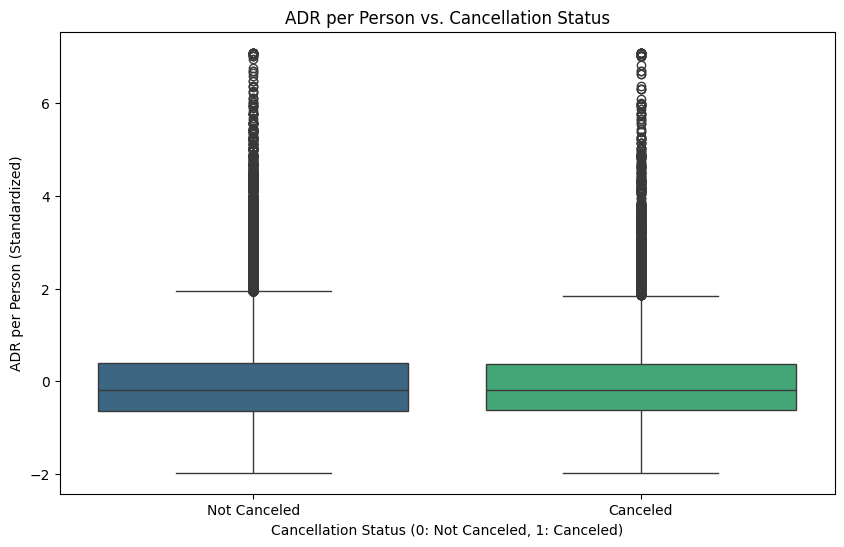

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_canceled', y='adr_per_person', data=df, palette='viridis', hue='is_canceled', legend=False)
plt.title('ADR per Person vs. Cancellation Status')
plt.xlabel('Cancellation Status (0: Not Canceled, 1: Canceled)')
plt.ylabel('ADR per Person (Standardized)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.show()

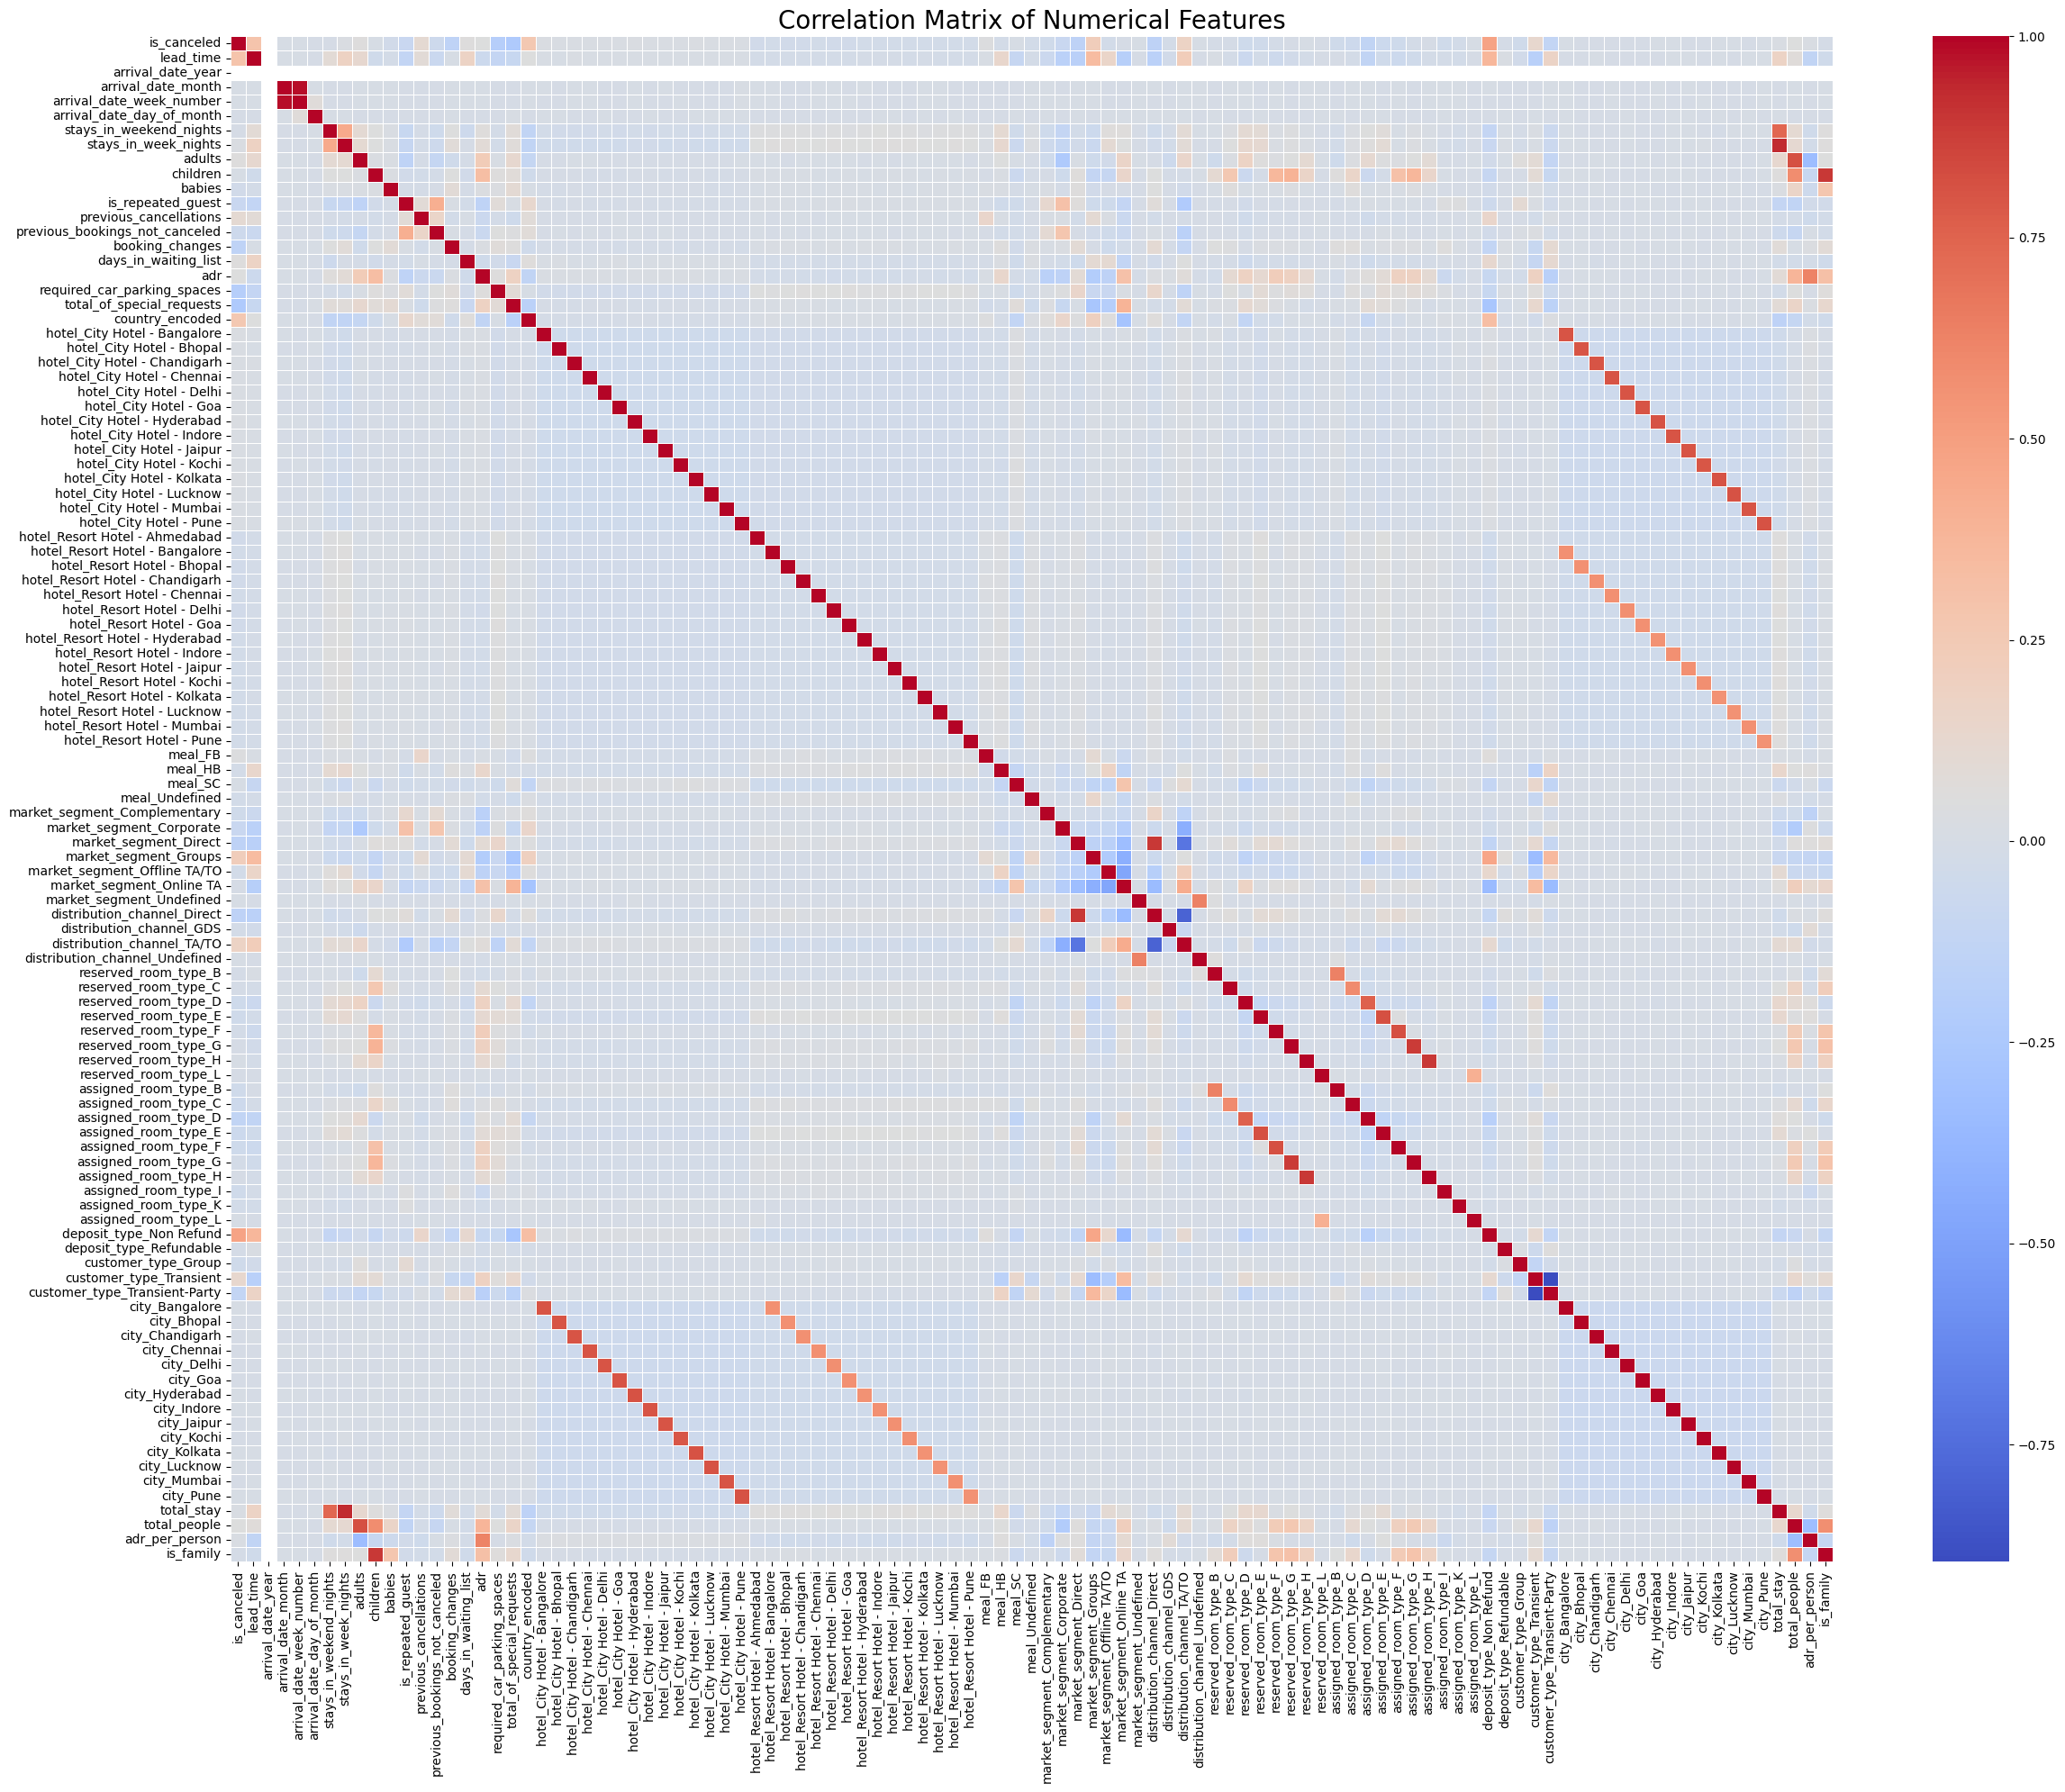

In [ ]:


# Select only numerical columns for correlation matrix
# 'is_canceled' is the target variable, so exclude it for correlation analysis with features if needed,
# but for a general correlation matrix of numerical features, it's fine to include it.
# Let's include all numerical columns that are still in the df.

# Re-get numeric columns after previous operations, including 'is_canceled' for a comprehensive matrix.
# numeric_cols from previous step was defined to exclude 'is_canceled', so recalculate.
all_numeric_cols = df.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

# Convert boolean columns to int if any exist, as corr() might treat them differently
for col in df.select_dtypes(include='bool').columns:
    df[col] = df[col].astype(int)

# Recalculate all_numeric_cols after type conversion
all_numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Calculate the correlation matrix
correlation_matrix = df[all_numeric_cols].corr()

# Set up the matplotlib figure
plt.figure(figsize=(25, 20)) # Increased figure size for better readability of many features

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

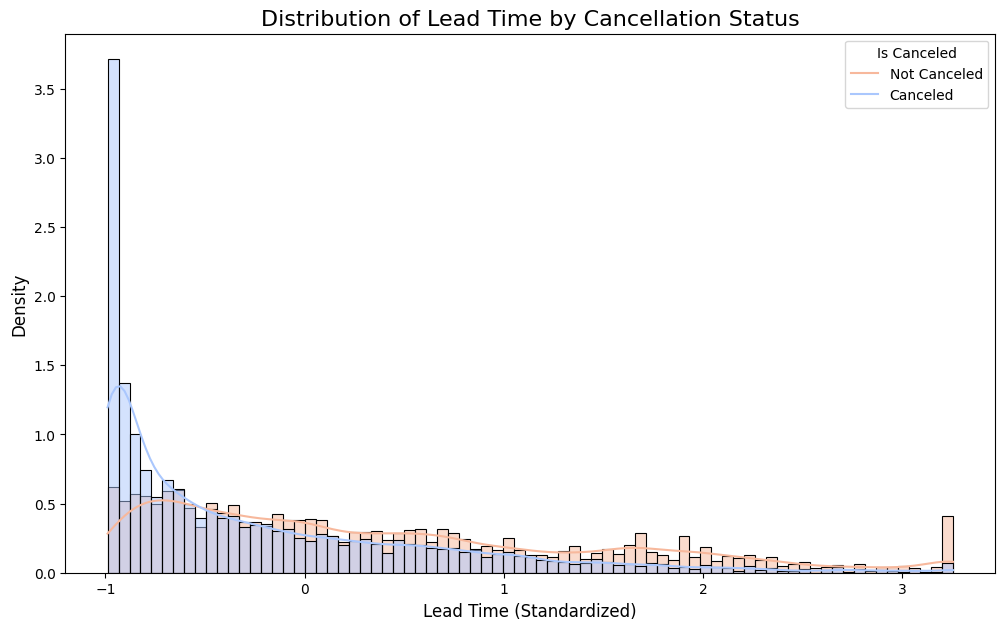

In [ ]:


plt.figure(figsize=(12, 7))
sns.histplot(data=df, x='lead_time', hue='is_canceled', kde=True, stat='density', common_norm=False, palette='coolwarm')
plt.title('Distribution of Lead Time by Cancellation Status', fontsize=16)
plt.xlabel('Lead Time (Standardized)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'])
plt.show()

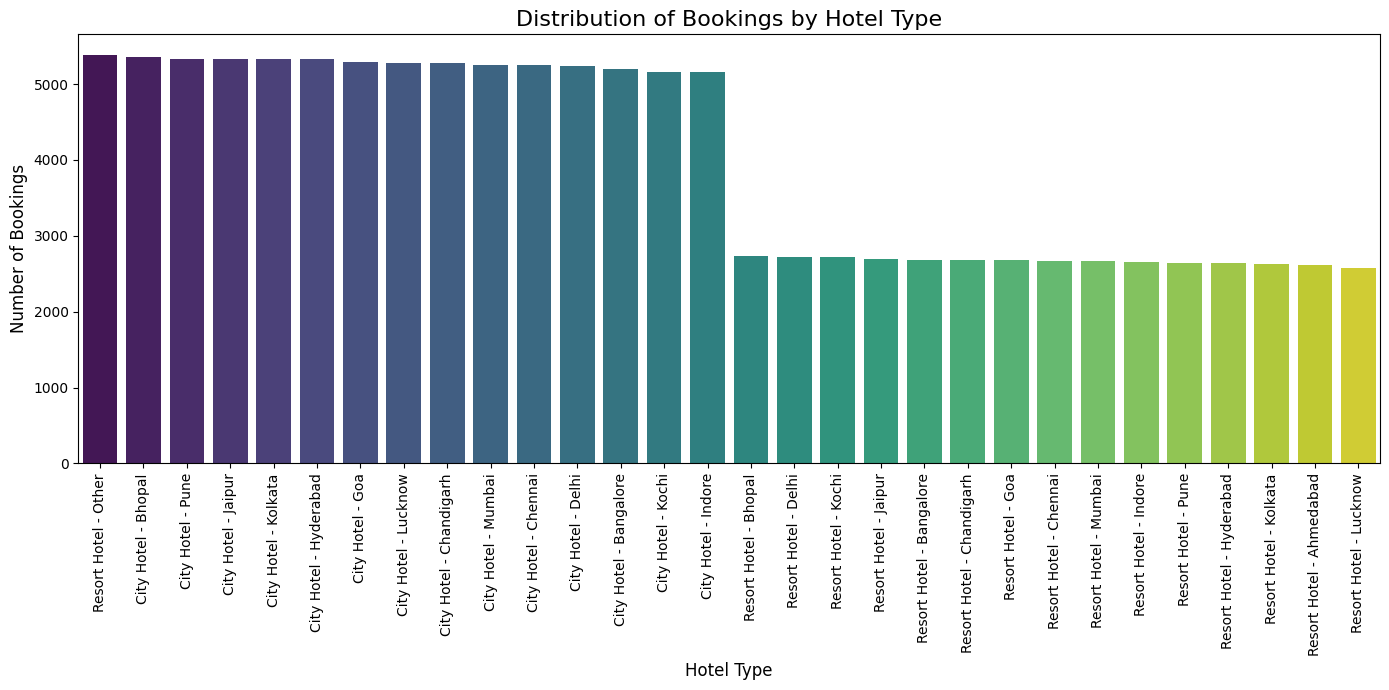

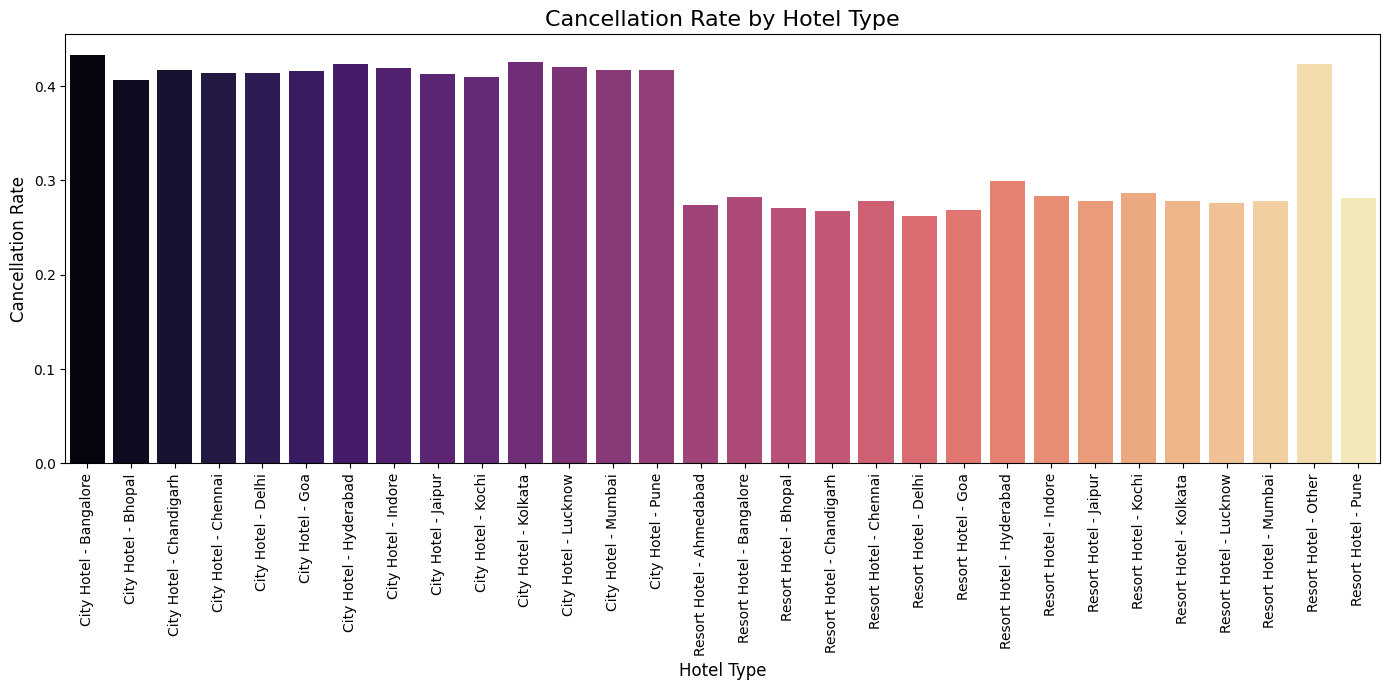

In [ ]:

# Create a temporary DataFrame to reconstruct the 'hotel' type
df_temp = df.copy()

# Identify all one-hot encoded hotel columns
hotel_ohe_cols = [col for col in df_temp.columns if col.startswith('hotel_')]

# Reconstruct the 'hotel_type' column
# Initialize with a default value for the category dropped by drop_first=True
df_temp['hotel_type'] = 'Resort Hotel - Other'

# Assign the actual hotel type based on the one-hot encoded columns
for col in hotel_ohe_cols:
    hotel_name = col.replace('hotel_', '')
    df_temp.loc[df_temp[col] == 1, 'hotel_type'] = hotel_name

# 1. Calculate booking counts for each hotel type
booking_counts = df_temp['hotel_type'].value_counts().reset_index()
booking_counts.columns = ['hotel_type', 'booking_count']

# 2. Calculate the cancellation rate for each hotel type
cancellation_data = df_temp.groupby('hotel_type')['is_canceled'].agg(['count', 'sum'])
cancellation_data.columns = ['total_bookings', 'canceled_bookings']
cancellation_data['cancellation_rate'] = cancellation_data['canceled_bookings'] / cancellation_data['total_bookings']
cancellation_data = cancellation_data.reset_index()

# 3. Create a bar chart showing the distribution of bookings by hotel type
plt.figure(figsize=(14, 7))
sns.barplot(x='hotel_type', y='booking_count', hue='hotel_type', data=booking_counts, palette='viridis', legend=False)
plt.title('Distribution of Bookings by Hotel Type', fontsize=16)
plt.xlabel('Hotel Type', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 4. Create a bar chart showing the cancellation rate for each hotel type
plt.figure(figsize=(14, 7))
sns.barplot(x='hotel_type', y='cancellation_rate', hue='hotel_type', data=cancellation_data, palette='magma', legend=False)
plt.title('Cancellation Rate by Hotel Type', fontsize=16)
plt.xlabel('Hotel Type', fontsize=12)
plt.ylabel('Cancellation Rate', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

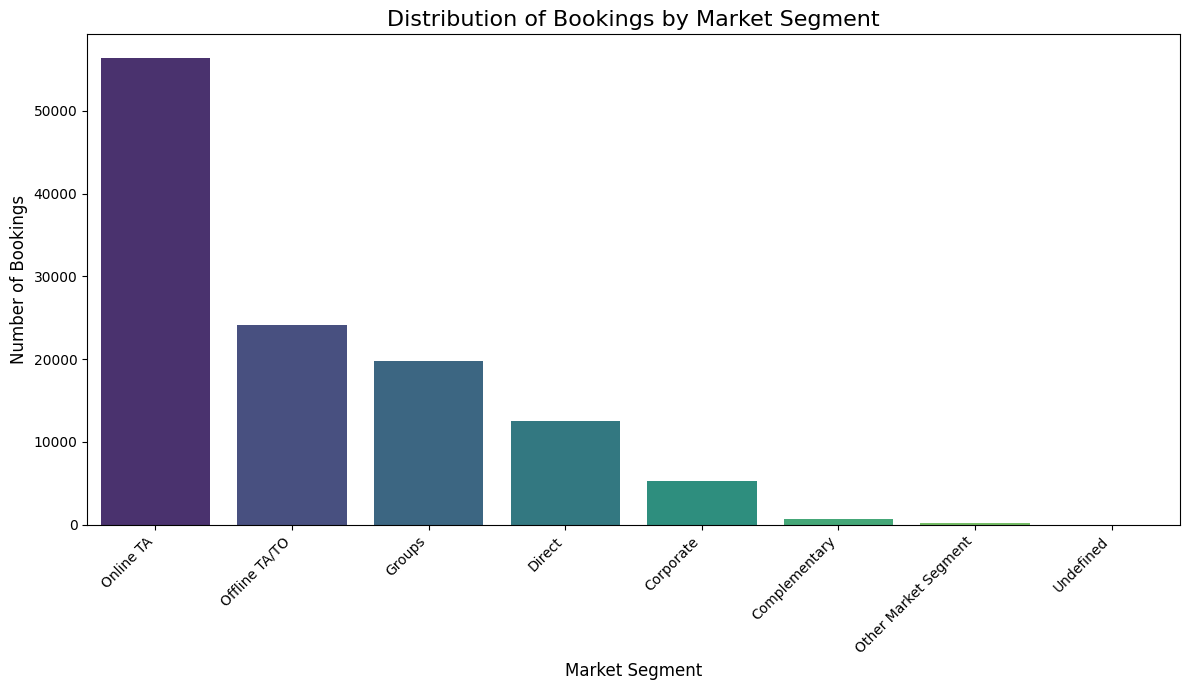

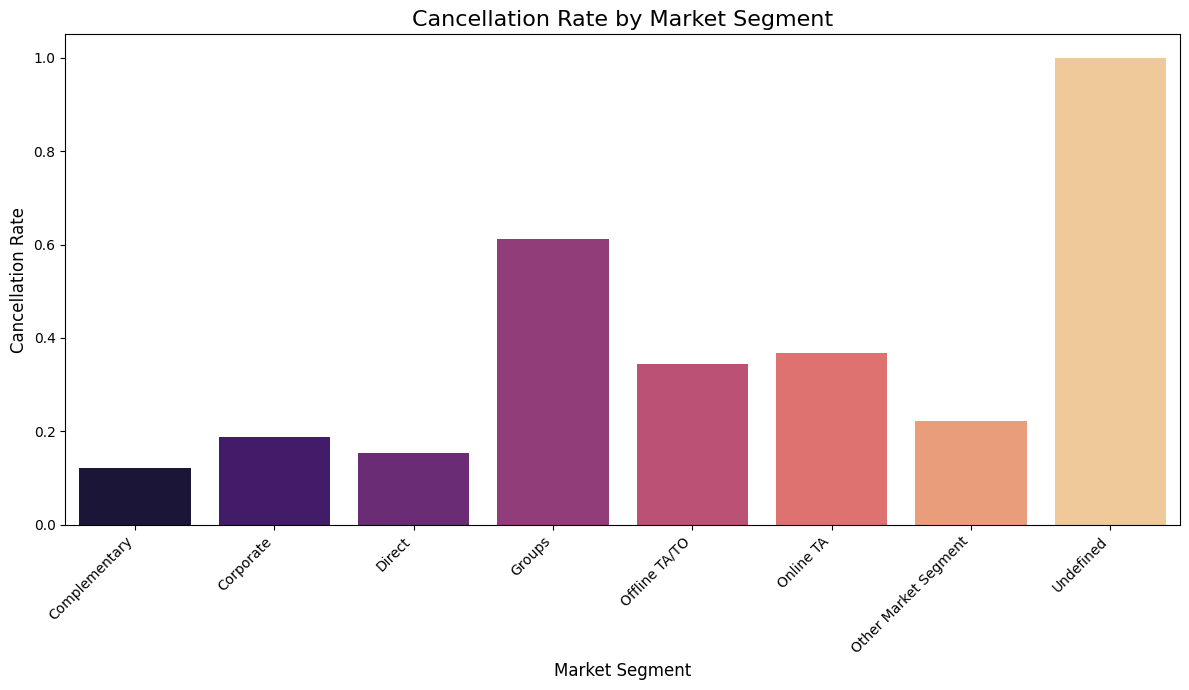

In [ ]:

# 1. Create a temporary DataFrame for this analysis
df_temp = df.copy()

# 2. Identify all columns that correspond to the one-hot encoded 'market_segment' categories
market_segment_ohe_cols = [col for col in df_temp.columns if col.startswith('market_segment_')]

# 3. Reconstruct the original 'market_segment' column
# Initialize with a default value for the category dropped by drop_first=True
# Based on the available OHE columns, the dropped one could be 'Aviation' or 'Complementary' or 'Undefined'.
# We'll use a generic 'Other Market Segment' as default.
df_temp['market_segment_type'] = 'Other Market Segment'

# Assign the actual market segment type based on the one-hot encoded columns
for col in market_segment_ohe_cols:
    segment_name = col.replace('market_segment_', '')
    df_temp.loc[df_temp[col] == 1, 'market_segment_type'] = segment_name

# 4. Calculate the total number of bookings for each unique 'market_segment'
market_segment_booking_counts = df_temp['market_segment_type'].value_counts().reset_index()
market_segment_booking_counts.columns = ['market_segment_type', 'booking_count']

# 5. Calculate the cancellation rate for each 'market_segment'
market_segment_cancellation_data = df_temp.groupby('market_segment_type')['is_canceled'].agg(['count', 'sum'])
market_segment_cancellation_data.columns = ['total_bookings', 'canceled_bookings']
market_segment_cancellation_data['cancellation_rate'] = market_segment_cancellation_data['canceled_bookings'] / market_segment_cancellation_data['total_bookings']
market_segment_cancellation_data = market_segment_cancellation_data.reset_index()

# 6. Generate a bar chart showing the distribution of bookings by 'market_segment'
plt.figure(figsize=(12, 7))
sns.barplot(x='market_segment_type', y='booking_count', hue='market_segment_type', data=market_segment_booking_counts, palette='viridis', legend=False)
plt.title('Distribution of Bookings by Market Segment', fontsize=16)
plt.xlabel('Market Segment', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 7. Generate a bar chart showing the cancellation rate for each 'market_segment'
plt.figure(figsize=(12, 7))
sns.barplot(x='market_segment_type', y='cancellation_rate', hue='market_segment_type', data=market_segment_cancellation_data, palette='magma', legend=False)
plt.title('Cancellation Rate by Market Segment', fontsize=16)
plt.xlabel('Market Segment', fontsize=12)
plt.ylabel('Cancellation Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

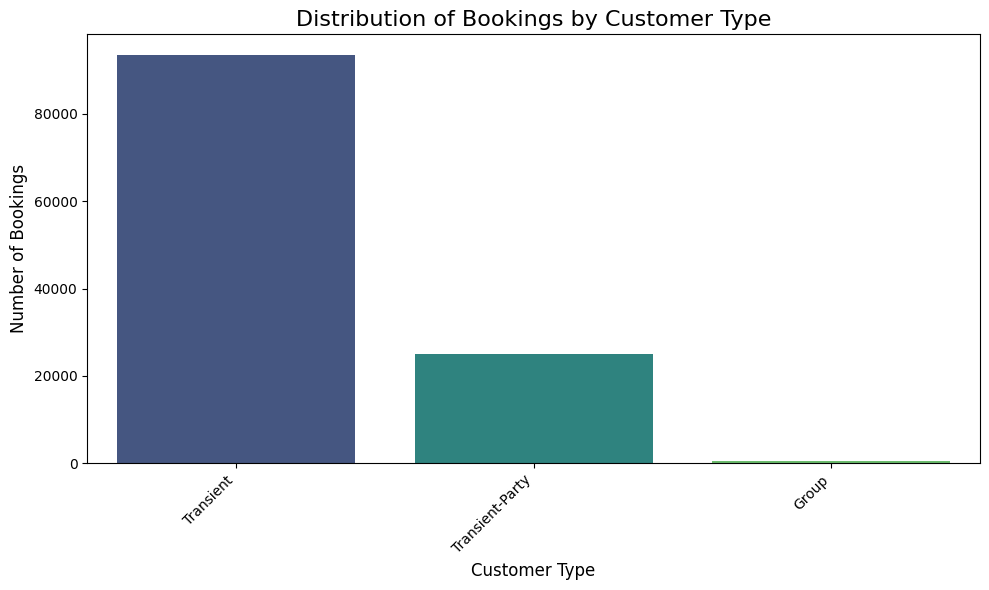

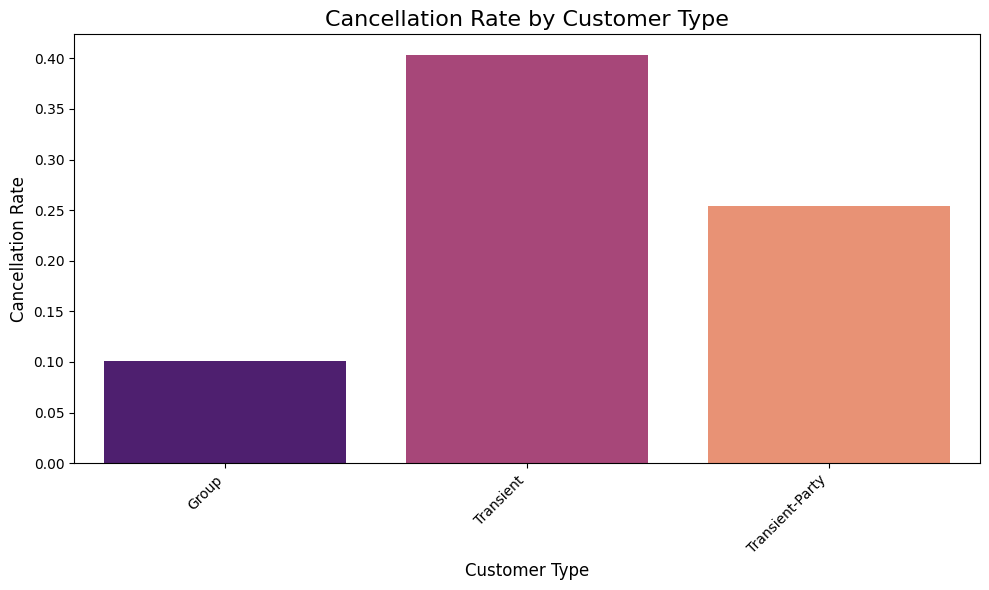

In [ ]:


# 1. Create a temporary DataFrame for this analysis
df_temp = df.copy()

# 2. Identify all columns that correspond to the one-hot encoded 'customer_type' categories
customer_type_ohe_cols = [col for col in df_temp.columns if col.startswith('customer_type_')]

# 3. Reconstruct the original 'customer_type' column
# Initialize with a default value for the category dropped by drop_first=True (likely 'Transient')
df_temp['customer_type'] = 'Transient'

# Assign the actual customer type based on the one-hot encoded columns
for col in customer_type_ohe_cols:
    customer_type_name = col.replace('customer_type_', '')
    df_temp.loc[df_temp[col] == 1, 'customer_type'] = customer_type_name

# 4. Calculate the total number of bookings for each unique 'customer_type'
customer_type_booking_counts = df_temp['customer_type'].value_counts().reset_index()
customer_type_booking_counts.columns = ['customer_type', 'booking_count']

# 5. Calculate the cancellation rate for each 'customer_type'
customer_type_cancellation_data = df_temp.groupby('customer_type')['is_canceled'].agg(['count', 'sum'])
customer_type_cancellation_data.columns = ['total_bookings', 'canceled_bookings']
customer_type_cancellation_data['cancellation_rate'] = customer_type_cancellation_data['canceled_bookings'] / customer_type_cancellation_data['total_bookings']
customer_type_cancellation_data = customer_type_cancellation_data.reset_index()

# 6. Generate a bar chart showing the distribution of bookings by 'customer_type'
plt.figure(figsize=(10, 6))
sns.barplot(x='customer_type', y='booking_count', hue='customer_type', data=customer_type_booking_counts, palette='viridis', legend=False)
plt.title('Distribution of Bookings by Customer Type', fontsize=16)
plt.xlabel('Customer Type', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 7. Generate a bar chart showing the cancellation rate for each 'customer_type'
plt.figure(figsize=(10, 6))
sns.barplot(x='customer_type', y='cancellation_rate', hue='customer_type', data=customer_type_cancellation_data, palette='magma', legend=False)
plt.title('Cancellation Rate by Customer Type', fontsize=16)
plt.xlabel('Customer Type', fontsize=12)
plt.ylabel('Cancellation Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

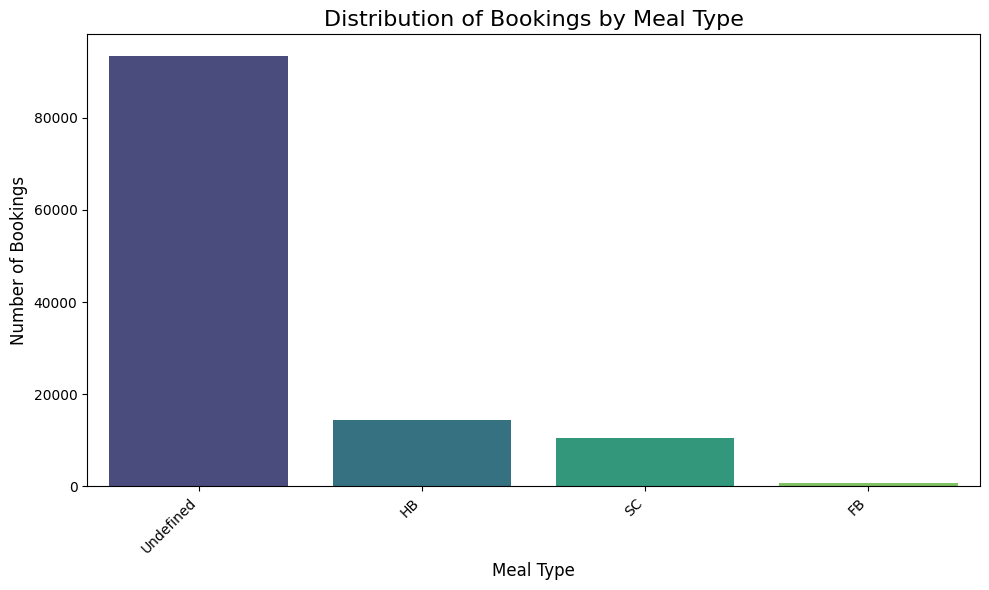

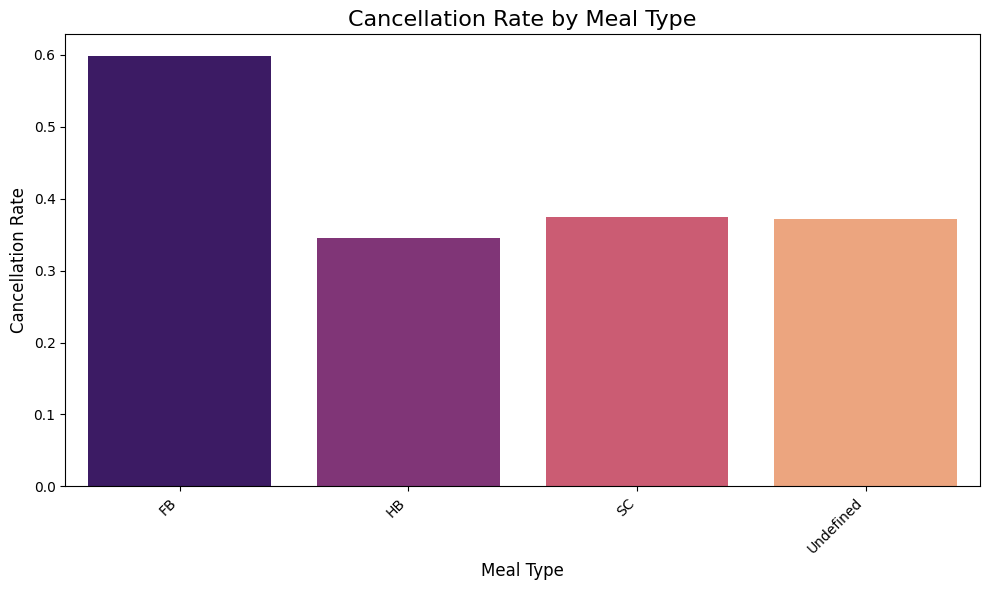

In [ ]:


# 1. Create a temporary DataFrame for this analysis
df_temp = df.copy()

# 2. Identify all columns that correspond to the one-hot encoded 'meal' categories
meal_ohe_cols = [col for col in df_temp.columns if col.startswith('meal_')]

# 3. Reconstruct the original 'meal' column
# Initialize with a default value for the category dropped by drop_first=True.
# Given that 'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC' are present,
# and there were 5 unique meal types, the fifth (implicitly dropped) is likely 'Undefined' or 'No Meal'.
# We'll use 'Undefined' as the default for now.
df_temp['meal_type'] = 'Undefined'

# Assign the actual meal type based on the one-hot encoded columns
for col in meal_ohe_cols:
    meal_name = col.replace('meal_', '')
    df_temp.loc[df_temp[col] == 1, 'meal_type'] = meal_name

# 4. Calculate the total number of bookings for each unique 'meal_type'
meal_booking_counts = df_temp['meal_type'].value_counts().reset_index()
meal_booking_counts.columns = ['meal_type', 'booking_count']

# 5. Calculate the cancellation rate for each 'meal_type'
meal_cancellation_data = df_temp.groupby('meal_type')['is_canceled'].agg(['count', 'sum'])
meal_cancellation_data.columns = ['total_bookings', 'canceled_bookings']
meal_cancellation_data['cancellation_rate'] = meal_cancellation_data['canceled_bookings'] / meal_cancellation_data['total_bookings']
meal_cancellation_data = meal_cancellation_data.reset_index()

# 6. Generate a bar chart showing the distribution of bookings by 'meal_type'
plt.figure(figsize=(10, 6))
sns.barplot(x='meal_type', y='booking_count', hue='meal_type', data=meal_booking_counts, palette='viridis', legend=False)
plt.title('Distribution of Bookings by Meal Type', fontsize=16)
plt.xlabel('Meal Type', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 7. Generate a bar chart showing the cancellation rate for each 'meal_type'
plt.figure(figsize=(10, 6))
sns.barplot(x='meal_type', y='cancellation_rate', hue='meal_type', data=meal_cancellation_data, palette='magma', legend=False)
plt.title('Cancellation Rate by Meal Type', fontsize=16)
plt.xlabel('Meal Type', fontsize=12)
plt.ylabel('Cancellation Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [59]:
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

print(f"Original dataset shape: X={X.shape}, y={y.shape}")
print(f"Original target distribution:\n{y.value_counts()}")

Original dataset shape: X=(119193, 105), y=(119193,)
Original target distribution:
is_canceled
0    75006
1    44187
Name: count, dtype: int64


In [56]:
X = df.drop(['is_canceled', 'reservation_status_date'], axis=1)
y = df['is_canceled']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Resampled dataset shape: X_resampled={X_resampled.shape}, y_resampled={y_resampled.shape}")
print(f"Resampled target distribution:\n{y_resampled.value_counts()}")

Resampled dataset shape: X_resampled=(150012, 104), y_resampled=(150012,)
Resampled target distribution:
is_canceled
0    75006
1    75006
Name: count, dtype: int64
